In [15]:
import numpy as np
from scipy.integrate import quad  
from matplotlib import pyplot as plt
from sympy import *

In [16]:
class Quadrature:
    '''
    This class performs quadrature by:
    1) creating orthogonal polynomials based on the provided weight function, 
    2) finding their roots using bisection + Newton with the "recurrence" relation between 
    roots of subsequent orthogonal polynomials,
    3) solves the Vandermonde system for coefficients of quadrature
    4) computes integral
    
    It returns the value of the integral (with the Vandermonde system if requested),
    and prints graphs if requested.
    '''
    def __init__(self, funs, n, weightFun, a, b, weighted = True, print_matrices = False):
        
        x = Symbol('x')

        self.f = funs
        self.order = n
        self.weight = weightFun
        self.a = a
        self.b = b
        self.weighted = weighted
        self.printM = print_matrices
        self.polys = self.build_poly(order = self.order)
        self.nodes = self.find_roots()
        self.value = self.performQuad()
        
    def _btop(self, x, p):
        return x*self.weight(x)*(p(x))**2

    def _btom(self, x, p):
        return self.weight(x)*(p(x))**2

    def _ctop(self, x, p1, p2):
        return x*self.weight(x)*p1(x)*p2(x)
    
    def build_poly(self, order):
        """
        Builds sets of orthogonal polynomials based on provided weight function and 
        specified highest order.
        Returns list of polynomials from order 0 to order n (as specified).
        """

        def _phi_1(x):
            return x - bk

        def _phi0(x):
            return 1

        phi1 = _phi0(Symbol('x')) #phi_0 = 1 by definition
        bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
        phi2 = _phi_1(Symbol('x'))
        phis = [phi1, phi2]

        if order == 0:
            return [phi1]
        if order == 1:
            return phis
        else:
            k = 2
            while k <= order:
                phis1 = lambdify(x, phis[k-1])
                phis2 = lambdify(x, phis[k-2])

                bktop = quad(self._btop, self.a, self.b, args=(phis1))[0]
                bktom = quad(self._btom, self.a, self.b, args=(phis1))[0]
                bk = bktop/bktom

                cktop = quad(self._ctop, self.a, self.b, args=(phis1, phis2))[0]
                cktom = quad(self._btom, self.a, self.b, args=(phis2))[0]
                ck = cktop/cktom

                p1 = self.build_poly(k-1)[-1]
                p2 = self.build_poly(k-2)[-1]

                phi2 = (x-bk)*p1-ck*p2

                phis.append(phi2)
                k+=1

            return phis

    def find_roots(self):
        '''
        Finds roots of polynomials using bisection and Newton with "root formula"
        relating lower order roots to higher order roots for orthogonal polynomials.
        Returns list of roots of highest order polynomial.
        '''
        if self.order < 2:
            raise Exception('Order < 2 is not very interesting. Try a higher one!')

        # First order
        rootList = [self._bisecNewton(lambdify(x, self.polys[1]), self.a, self.b, self.order, 10**(-self.order*2))]
        o = 2
        while o <= self.order:
            prevRoots = rootList
            rootList = []
            for j in range(o):
                if j == 0: 
                    xa = self.a
                    xb = prevRoots[j]

                elif j == len(prevRoots):
                    xa = prevRoots[j-1]
                    xb = self.b
                else:
                    xa = prevRoots[j-1]
                    xb = prevRoots[j]

                rootList.append(self._bisecNewton(lambdify(x, self.polys[o]), xa, xb, o, 10**(-o*2)))
            o+=1

        return rootList

    def _bisecNewton(self, funs, a, b, order, tol):
        '''
        This function runs the bisection method until
        we reach the basin of convergence for Newton,
        in which case we jump to Newton's method
        It returns the root of funs between a and b
        '''
#         f = funs(Symbol('x'))
#         fx = lambdify(x, f.diff(x))
        
#         print(np.linalg.norm(fx))
        while abs(funs(a)-funs(b)) >= 10**(-order): # replace by basin of convergence?
            a, b = self._bisect(funs, a, b, tol, 100)
        else:
            if abs(funs((a+b)/2)) <= 10**(-2*order):
                # sometimes bisection is enough!
                return (a+b)/2
            else:
                p = self._newton(funs, a, b, 10**(-2*order), 100)
                return p

    def _bisect(self, funs, a, b, tol, Nmax):
        '''
        This is the bisection method
        '''

        if np.sign(funs(a)) == np.sign(funs(b)):
            raise Exception('there is no root between a and b!')

        p = (a+b)/2
        n = 1

        while np.abs(funs(p)) >= tol or n < Nmax:
            if np.sign(funs(a)) == np.sign(funs(p)):
                a = p
            else:
                b = p
            p = (a+b)/2
            n += 1

        return a, b

    def _newton(self, funs, p, tol, n):
        '''
        This is Newton's method
        '''
        i = 0
        ae = 1

        f = funs(Symbol('x'))

        while i < n and ae > tol: 
            # compute derivative
            fx = lambdify(x, f.diff(x))

            #iteration
            p1 = p - fx(p)/funs(p)

            ae = np.abs(p - p1) #absolute error
            p = p1
            i += 1

        if i == n:
            return 'iteration did not converge'
        else:
            return p
        
    def performQuad(self):
        """
        Performs quadrature, returns the value of the integral and, if requested,
        the Vandermonde matrix and its associated RHS for the linear system 
        that we solve to get the coefficients of our quadrature.
        """
        polyFuns = [lambdify(x, p) for p in self.polys]
        
        RHS = np.array([quad(lambda x: p(x)*self.weight(x), self.a, self.b)[0] for p in polyFuns[:self.order]])
        Vndmd = np.empty((self.order,self.order))
        for i in range(self.order):
            for j in range(self.order):
                Vndmd[i,j] = polyFuns[i](self.nodes[j])

        coefs = np.matmul(np.linalg.inv(Vndmd), RHS)
        
        if self.weighted == True:
            self.coefs = coefs
        else:
            self.coefs = [coefs[i]*(1/self.weight(self.nodes[i])) for i in range(self.order)]
        
        quadVal = 0
        for i in range(self.order):
            quadVal += self.coefs[i]*self.f(self.nodes[i])

        if self.printM == True:
            return quadVal, Vndmd, RHS
        else:
            return quadVal
        
    def print_polys(self, fileName = 'None.png'):
        '''
        Prints graph of polynomials
        '''
        xs = np.linspace(self.a, self.b, 100)
        yarr = np.empty((self.order-1, 100))
        for i in range(len(yarr)):
            yarr[i] = [lambdify(x, self.polys[i+1])(j) for j in xs]
            
        fig = plt.figure(figsize = (6, 3), dpi = 200)
        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        for i in range(len(yarr)):
            plt.plot(xs, yarr[i], label= str(i+1))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Generated orthogonal polynomials')
        ax.legend(title = r'order$^*$')
        plt.figtext(0.1, 0.01, r"$^*$order 0 polynomial ($f(x) = 1$) not included", ha = 'left', fontsize=6)
        fig.savefig(fileName)
        plt.show()
        
    def print_roots(self, poly = False, fileName = 'None.png'):
        xs = np.linspace(-1, 1, 100)
        if poly == False: yarr = [self.f(j) for j in xs]
        else: yarr = [lambdify(x, self.polys[self.order])(j) for j in xs]

        fig = plt.figure(figsize = (6, 3), dpi = 200)
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(xs, yarr)
        if poly == False:
            for i in range(len(self.nodes)):
                ax.vlines(self.nodes[i], -0.5, self.f(self.nodes[i]), color = 'red', linestyle = '--')
        else:
            for i in range(len(self.nodes)):
                ax.vlines(self.nodes[i], -0.5, lambdify(x, self.polys[self.order])(self.nodes[i]), color = 'red', linestyle = '--')
        ax.set_ylabel('y')
        ax.set_title('Function to integrate and its nodes')
        ax.legend()
        ax.grid()
        fig.savefig(fileName)
        plt.show()

In [72]:
mquad = Quadrature(p, 3, Tchbshv, -1, 1, weighted=True)
mquad.nodes

[-0.8660254037844537, -1.1156177909894302e-30, 0.8660254037844537]

In [75]:
mquad = Quadrature(p, 3, Legendre, -1, 1, weighted=True)
mquad.nodes 
actualnodes = [-0.7745966692414833770359, 0, 0.7745966692414833770359]
for i in range(len(mquad.nodes)):
    print(abs(mquad.nodes[i]-actualnodes[i]))

0.0
9.108981119650456e-31
0.0


In [41]:
def Tchbshv(x):
    return 1/np.sqrt(1-x**2)

def Legendre(x):
    return 1

def absW(x):
    return abs(x)

def expW(x):
    return np.exp(x)

def sqW(x):
    return x**2

def sq8W(x):
    return x**8

def GaussW(x):
    return (1/np.sqrt(2*np.pi))*np.exp(x**2/2)

def sinW(x):
    return np.sin(x)**2

def cosW(x):
    return np.cos(x)**2

def linW(x):
    return 5-x

def logW(x):
    return np.log(x + 10)

def W100(x):
    return 1000

def discW(x):
    if x > 0:
        return 1/x
    elif x < 0:
        return 1/(-x)
    else:
        return 0

def disc2W(x):
    if x > 0:
        return 1
    elif x <= 0:
        return 2
    
def disc3W(x):
    if x > -0.9 and x < 0.9:
        return 0
    else:
        return 1
    
def disc4W(x):
    if x > -0.99 and x < 0.99:
        return 0
    else:
        return 1

In [65]:
x = Symbol('x')

def fex1(x):
    return np.exp(x)*np.cos(x)

def fex2(x):
    return x**4/(np.sqrt(1 - x**2))

def fex3(x):
    return x**4

def fex4(x):
    return x**8

def fex5(x):
    return x 

def log5(x):
    return np.log(x+5)

def badzero(x):
    return np.sin(1/x)

def flat(x):
    return 1

In [84]:
def mnml1(x):
    return x + 1
def mnml2(x):
    return x**2 + 1
def mnml3(x):
    return x**3 + 1
def mnml4(x):
    return x**4 + 1
def mnml5(x):
    return x**5 + 1
def mnml6(x):
    return x**6 + 1

mnmList = [mnml1, mnml2, mnml3, mnml4, mnml5, mnml6]
for p in mnmList:
    mquad = Quadrature(p, 3, Tchbshv, -1, 1, weighted=True)
    truth = quad(lambda x:p(x)*Tchbshv(x), -1, 1)[0]
    print('Weighted Error: ' + str(round(abs(mquad.value - truth),16)))

#     mquad = Quadrature(lambda x: p(x)*1/Tchbshv(x), 3, Tchbshv, -1, 1, weighted=False)
#     truth = quad(lambda x: p(x)*1/Tchbshv(x), -1, 1)[0]
#     print('Non-weighted Error: ' + str(abs(mquad.value - truth)))

Weighted Error: 1.91e-14
Weighted Error: 4.26e-14
Weighted Error: 3.51e-14
Weighted Error: 3.162e-13
Weighted Error: 1.64e-14
Weighted Error: 0.0981747704248788


In [50]:
WList = [Tchbshv, Legendre, absW, expW, sqW, sinW, cosW, linW, logW, discW, log5, disc3W, disc4W]
WListNames = ['Tchebyshev', 'Legendre', 'Absolute Value', 'Exponential', 'Square', 'Sine', 'Cosine', 
              'w(x) = 5-x', 'Log', 'Discrete', 'w(x) = log(5+x)', 'Discrete 3', 'Discrete 4']

for i in range(len(WList)):
    GQfex1 = Quadrature(fex1, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    true_fex1 = quad(lambda x: fex1(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(abs(GQfex1.value-true_fex1)/abs(true_fex1)))

Tchebyshev: 2.643672914569979e-05
Legendre: 1.6047683589465945e-05
Absolute Value: 2.177376898772085e-05
Exponential: 2.5542830146491205e-05
Square: 2.3090730871678788e-05
Sine: 2.280726518220263e-05
Cosine: 1.0753493402059064e-05
w(x) = 5-x: 1.2542562305300514e-05
Log: 1.6715164741627914e-05
Discrete: 1.019994504956158e-06
w(x) = log(5+x): 1.788258691684528e-05
Discrete 3: 3.3858241988794863e-06
Discrete 4: 8.303904312630784e-08


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [53]:
GQfex1.nodes

[-0.9950207392875692, 0.0, 0.9950207392875692]

In [49]:
GQbadz.value

-0.4756223556657032

In [101]:
for i in range(len(WList)-1):
    GQbadz = Quadrature(badzero, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    #true_badz = quad(lambda x: badzero(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(GQbadz.value))
    #print(WListNames[i] + ': ' + str(abs(GQbadz.value-true_badz)))

Tchebyshev: -0.4756223556657032
Legendre: 0.7032053128240944
Absolute Value: 0.0217369309487499
Exponential: 1.3351072538668936
Square: -0.1035513691634628
Sine: -0.03979776367793317
Cosine: -0.7104564726357365
w(x) = 5-x: 0.8297657822849425
Log: -0.9725637355436747
Discrete: 34.458144533325516
w(x) = log(5+x): -1.0530638737098514
Discrete 3: -0.00017205722175338278


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [44]:
for i in range(len(WList)):
    GQfex5 = Quadrature(fex5, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    true_fex5 = quad(lambda x: fex5(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(abs(GQfex5.value-true_fex5)))

Tchebyshev: 0.0
Legendre: 1.1102230246251565e-16
Absolute Value: 5.551115123125783e-17
Exponential: 0.0
Square: 0.0
Sine: 2.7755575615628914e-17
Cosine: 0.0
w(x) = 5-x: 2.220446049250313e-16
Log: 4.163336342344337e-16
Discrete: 5.551115123125783e-16
w(x) = log(5+x): 2.7755575615628914e-16
Discrete 3: 0.0
Discrete 4: 0.0


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [68]:
GQflat.value

nan

In [67]:
for i in range(len(WList)):
    GQflat = Quadrature(toughfun, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    true_flat = quad(lambda x: flat(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(abs(GQflat.value-true_flat)))

Tchebyshev: 0.002617012305580868
Legendre: 0.0011107778253927059
Absolute Value: 0.0008330555996431954
Exponential: 0.0014643474649060906
Square: 0.0006664286119170137
Sine: 0.0005232879794165868
Cosine: 0.0005874898471092127
w(x) = 5-x: 0.00555388912743382
Log: 0.0025543163571155603
Discrete: 0.0016662500495954191
w(x) = log(5+x): 0.0017742049215589972
Discrete 3: 0.0003009746372417965
Discrete 4: nan


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [57]:
for i in range(len(WList)):
    GQfex3 = Quadrature(fex3, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    true_fex3 = quad(lambda x: fex3(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] +  ': ' + str(abs(GQfex3.value-true_fex3)/abs(true_fex3)))

Tchebyshev: 9.687733963094772e-14
Legendre: 2.7755575615628914e-16
Absolute Value: 0.0
Exponential: 0.0
Square: 3.885780586188048e-16
Sine: 3.797782004585998e-16
Cosine: 1.5355861532546508e-16
w(x) = 5-x: 6.661338147750938e-16
Log: 3.621867670210164e-16
Discrete: 2.2204460492503135e-15
w(x) = log(5+x): 3.480486618603456e-16
Discrete 3: 7.62497193410449e-15
Discrete 4: 8.048257711006712e-07


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [69]:
for i in range(len(WList)):
    GQfex4 = Quadrature(fex4, 3, WList[i], -1, 1)
    #GQfex1.print_roots()    
    true_fex4 = quad(lambda x: fex4(x)*WList[i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(abs(GQfex4.value-true_fex4)/abs(true_fex4)))

Tchebyshev: 0.22857142856903206
Legendre: 0.3519999999999997
Absolute Value: 0.2592592592592584
Exponential: 0.2627015581737542
Square: 0.19825072886297462
Sine: 0.21500044172540256
Cosine: 0.44842786480477725
w(x) = 5-x: 0.34886126927366595
Log: 0.3520286033269439
Discrete: 0.499999999999998
w(x) = log(5+x): 0.3517679932832609
Discrete 3: 0.010837845918965704
Discrete 4: 0.00010259233022283573


<ipython-input-16-35d73dd98d36>:51: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bk = quad(self._btop, self.a, self.b, args=(_phi0))[0]/quad(self.weight, self.a, self.b)[0]
<ipython-input-16-35d73dd98d36>:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integr

In [24]:
WListNames = ['Tchebyshev', 'Legendre', r'$w(x) = x^8$']

T1 = Quadrature(fex1, 3, Tchbshv, -1, 1)
L1 = Quadrature(fex1, 3, Legendre, -1, 1)
Sq81 = Quadrature(fex1, 3, sq8W, -1, 1)

for i in range(len(WListNames)):
    true_fex1 = quad(lambda x: fex1(x)*[Tchbshv, Legendre, sq8W][i](x), -1, 1)[0]
    print(WListNames[i] + ': ' + str(abs([T1.value, L1.value, Sq81.value][i]-true_fex1)/abs(true_fex1)))

Tchebyshev: 2.643672914569979e-05
Legendre: 1.6047683589465945e-05
$w(x) = x^8$: 1.5118684473846595e-05


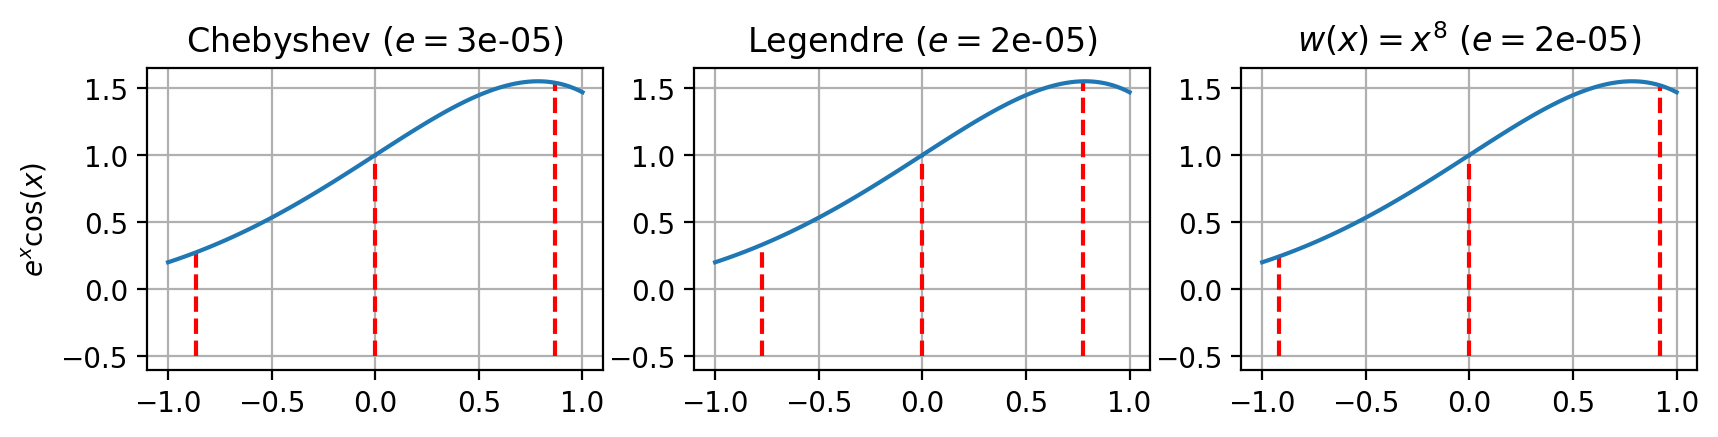

In [25]:
xs = np.linspace(-1, 1, 100)
fig = plt.figure(figsize = (10, 2), dpi = 200)
#______ Chebyshev
true_fex1 = quad(lambda x: fex1(x)*Tchbshv(x), -1, 1)[0]

ax1 = fig.add_subplot(131)
yarr = [T1.f(j) for j in xs]
ax1.plot(xs, yarr)
for r in T1.nodes:
    ax1.vlines(r, -0.5, T1.f(r), color = 'red', linestyle = '--')
ax1.set_ylabel(r'$e^x\cos(x)$')
ax1.set_title(r'Chebyshev ($e = $' + str(round(abs(T1.value-true_fex1)/abs(true_fex1), 5)) +')')
ax1.grid()

#______ Legendre
true_fex1 = quad(lambda x: fex1(x)*Legendre(x), -1, 1)[0]

ax2 = fig.add_subplot(132)
yarr = [L1.f(j) for j in xs]
ax2.plot(xs, yarr)
for r in L1.nodes:
    ax2.vlines(r, -0.5, L1.f(r), color = 'red', linestyle = '--')
ax2.set_title(r'Legendre ($e = $' + str(round(abs(L1.value-true_fex1)/abs(true_fex1), 5)) + ')')
ax2.grid()

#______ w(x) = x^8
true_fex1 = quad(lambda x: fex1(x)*sq8W(x), -1, 1)[0]

ax3 = fig.add_subplot(133)
yarr = [Sq81.f(j) for j in xs]
ax3.plot(xs, yarr)
for r in Sq81.nodes:
    ax3.vlines(r, -0.5, Sq81.f(r), color = 'red', linestyle = '--')
ax3.set_title(r'$w(x) = x^8$ ($e = $' + str(round(abs(Sq81.value-true_fex1)/abs(true_fex1), 5)) + ')')
ax3.grid()
plt.savefig('3graph.png')
plt.show()

In [76]:
L1.nodes

[-0.7745966692414834, -9.108981119650456e-31, 0.7745966692414834]

In [77]:
Sq81.nodes

[-0.9198662110078, -1.427103073308114e-30, 0.9198662110078]

In [78]:
T1.nodes

[-0.8660254037844537, -1.1156177909894302e-30, 0.8660254037844537]

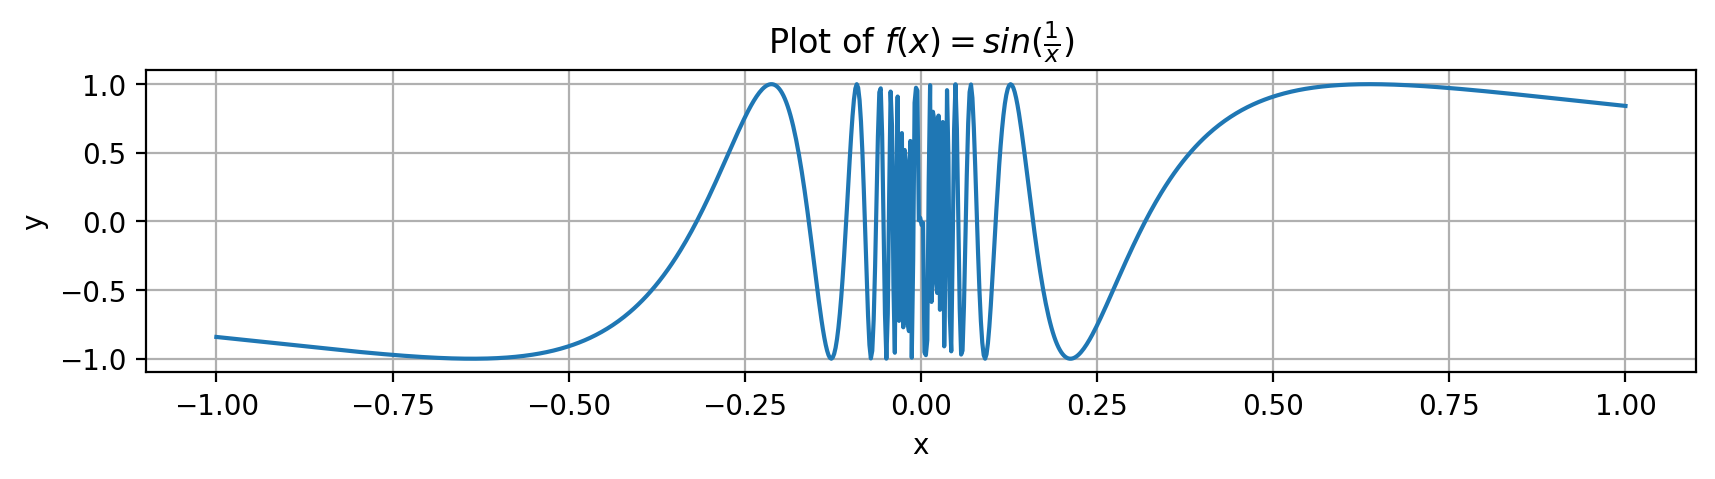

In [86]:
xs = np.linspace(-1, 1, 1000)
fig = plt.figure(figsize = (10, 2), dpi = 200)
ax = fig.add_subplot()
yarr = [badzero(j) for j in xs]
ax.plot(xs, yarr)
ax.set_title(r'Plot of $f(x) = sin(\frac{1}{x})$')
ax.grid()
ax.set_ylabel('y')
ax.set_xlabel('x')
plt.savefig('sine1overx.png')
plt.show()